In [1]:
import os
PROJECT_DIR = "C:\\Users\\reinhard_steffens\\Dropbox\\Udacity\\CarND-Vehicle-Detection"
TRAINING_DIR = "C:\\Users\\reinhard_steffens\\P5"


In [2]:
import glob
import numpy as np
import cv2
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
#from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split

In [3]:
VEH_SMALL = glob.glob(os.path.join(
        TRAINING_DIR,
        'vehicles_smallset',
        'vehicles_smallset',
        'cars*',
        '*.jpeg'
    ))
print(len(VEH_SMALL))

NO_VEH_SMALL = glob.glob(os.path.join(
        TRAINING_DIR,
        'non-vehicles_smallset',
        'non-vehicles_smallset',
        'notcars*',
        '*.jpeg'
    ))
print(len(NO_VEH_SMALL))

VEH = glob.glob(os.path.join(
        TRAINING_DIR,
        'vehicles',
        'vehicles',
        '*',
        '*.png'
    ))
print(len(VEH))

NO_VEH = glob.glob(os.path.join(
        TRAINING_DIR,
        'non-vehicles',
        'non-vehicles',
        '*',
        '*.png'
    ))
print(len(NO_VEH))

1196
1125
8792
8968


# Feature Extract Functions

In [4]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    if conv == 'RGB2HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if conv == 'RGB2YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)   

def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).reshape(-1)
    color2 = cv2.resize(img[:,:,1], size).reshape(-1)
    color3 = cv2.resize(img[:,:,2], size).reshape(-1)
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

### Test hog features on a few example images

In [5]:
def hog_tester(color='YCrCb', img_set=VEH, N=4):
    for _ in range(0, N):
        # Generate a random index to look at a car image
        ind = np.random.randint(0, len(img_set))
        # Read in the image
        image = mpimg.imread(img_set[ind])
        cimage = convert_color(image, conv='RGB2%s' % (color))
        orient = 9  # HOG orientations
        pix_per_cell = 8 # HOG pixels per cell
        cell_per_block = 2 # HOG cells per block
        hog1, img1 = get_hog_features(cimage[:,:,0], orient, pix_per_cell, cell_per_block, feature_vec=False, vis=True)
        hog2, img2 = get_hog_features(cimage[:,:,1], orient, pix_per_cell, cell_per_block, feature_vec=False, vis=True)
        hog3, img3 = get_hog_features(cimage[:,:,2], orient, pix_per_cell, cell_per_block, feature_vec=False, vis=True)

        # Plot the examples
        fig = plt.figure(figsize=(12,4))
        plt.subplot(141)
        plt.imshow(image, cmap='gray')
        plt.title('Example Image')
        plt.subplot(142)
        plt.imshow(img1, cmap='gray')
        plt.title('HOG %s 0' % (color))
        plt.subplot(143)
        plt.imshow(img2, cmap='gray')
        plt.title('HOG %s 1' % (color))
        plt.subplot(144)
        plt.imshow(img3, cmap='gray')
        plt.title('HOG %s 2' % (color))
        plt.show()

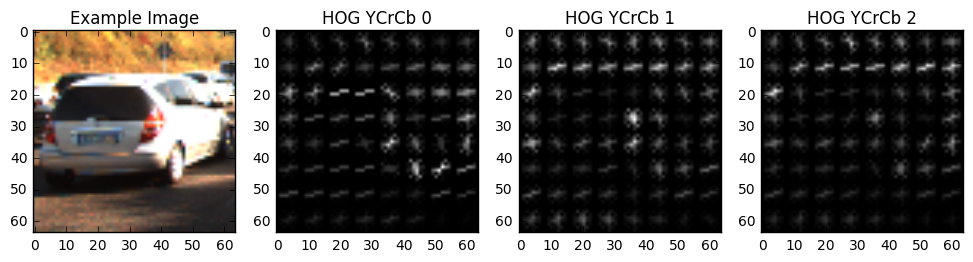

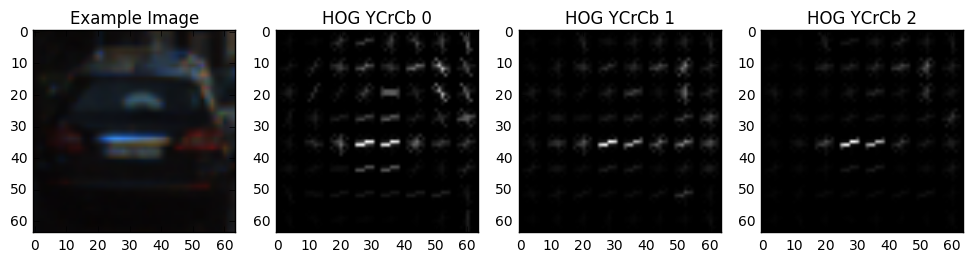

In [6]:
hog_tester('YCrCb', VEH, 2)

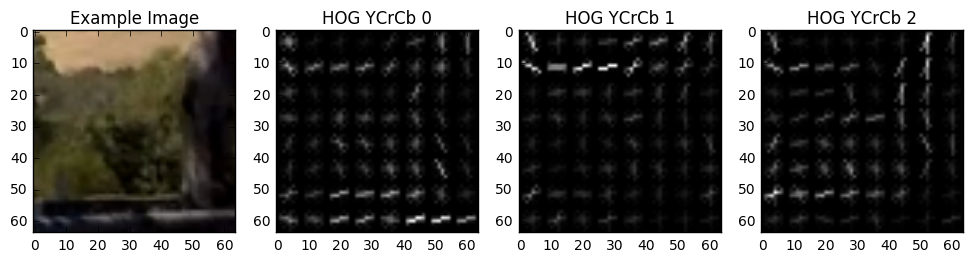

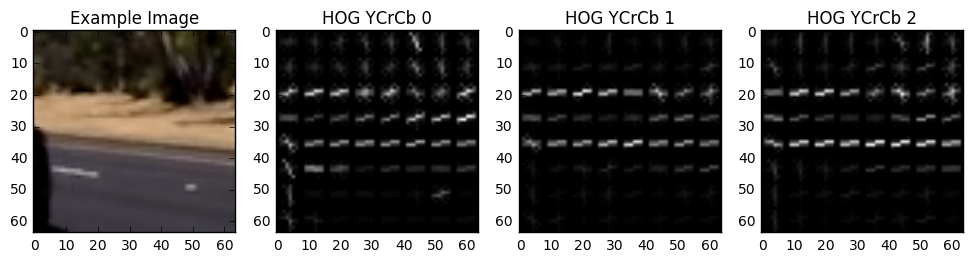

In [7]:
hog_tester('YCrCb', NO_VEH, N=2)

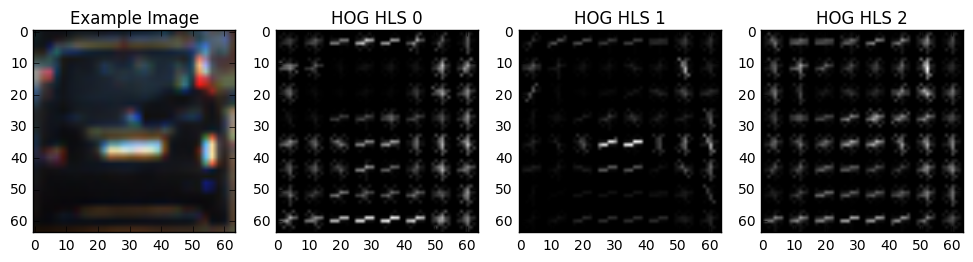

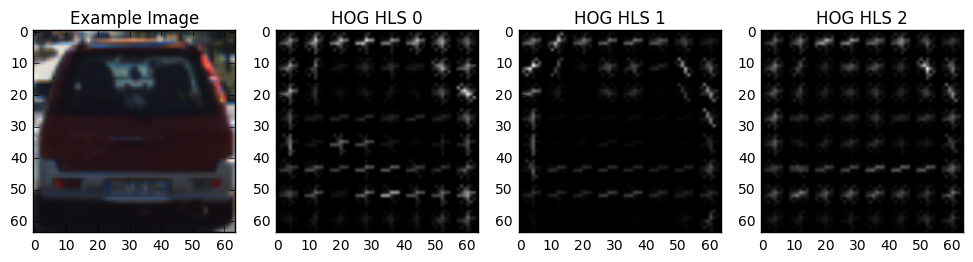

In [8]:
hog_tester('HLS', VEH, N=2)

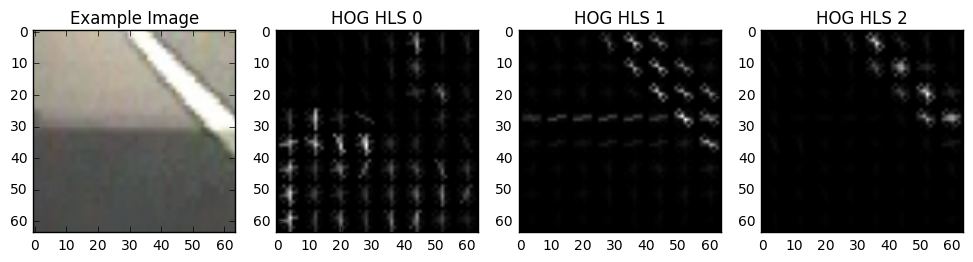

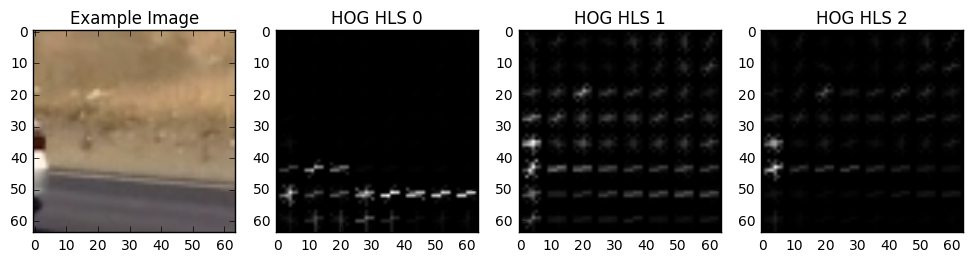

In [9]:
hog_tester('HLS', NO_VEH, N=2)

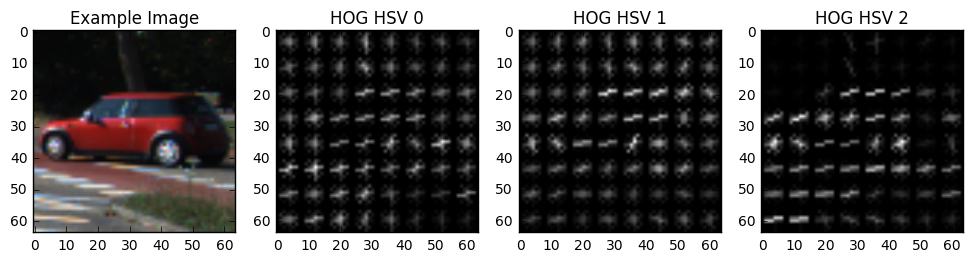

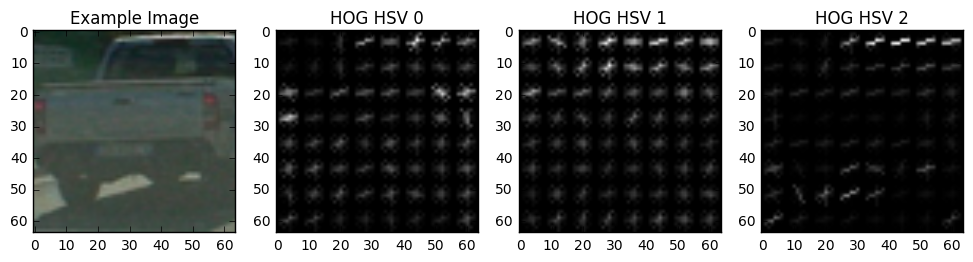

In [10]:
hog_tester('HSV', VEH, N=2)

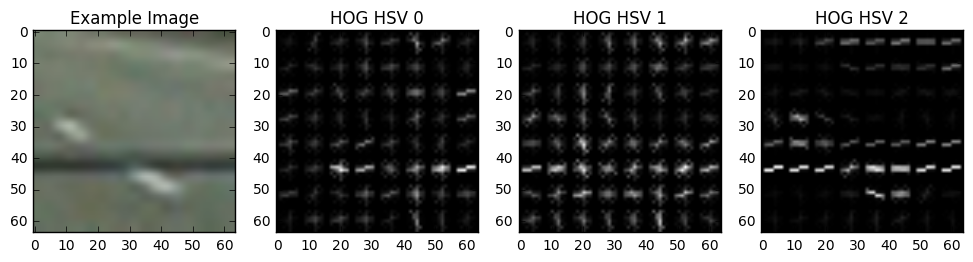

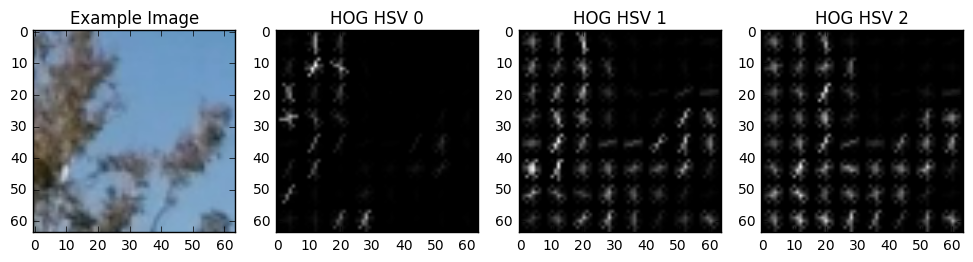

In [11]:
hog_tester('HSV', NO_VEH, N=2)

In [12]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs,
                     color_space,
                     spatial_size,
                     hist_bins,
                     orient, 
                     pix_per_cell,
                     cell_per_block,
                     hog_channel,
                     spatial_feat=True,
                     hist_feat=True,
                     hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            feature_image = convert_color(image, conv='RGB2%s' % (color_space))
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [13]:
car_features = extract_features(VEH_SMALL, color_space='YCrCb', spatial_size=(16, 16), hist_bins=16,
                                orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0,
                                spatial_feat=True, hist_feat=True, hog_feat=False)
notcar_features = extract_features(NO_VEH_SMALL, color_space='YCrCb', spatial_size=(16, 16), hist_bins=16,
                                   orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0,
                                   spatial_feat=True, hist_feat=True, hog_feat=False)

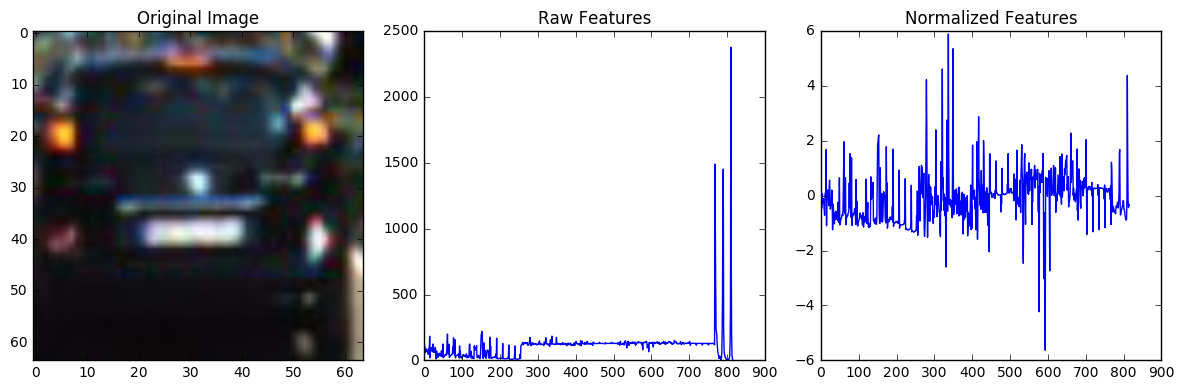

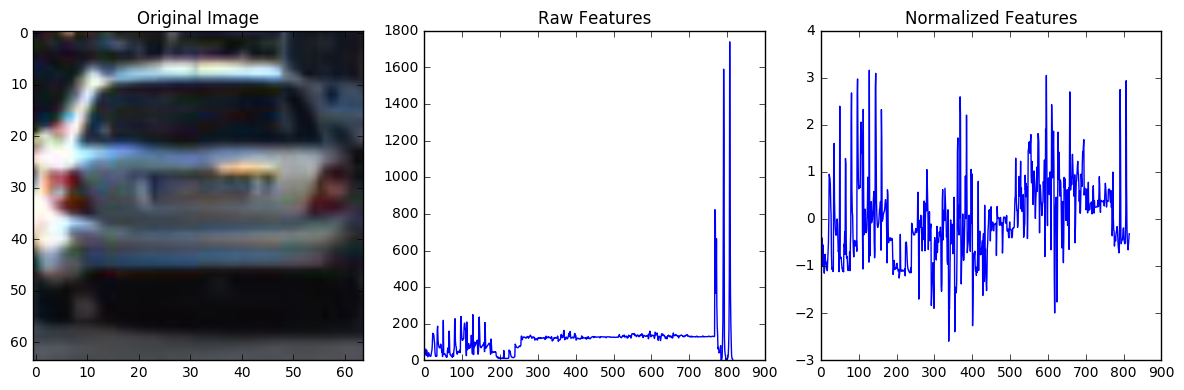

In [14]:
for _ in range(0, 2):
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    car_ind = np.random.randint(0, len(VEH_SMALL))
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(VEH_SMALL[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
    plt.show()

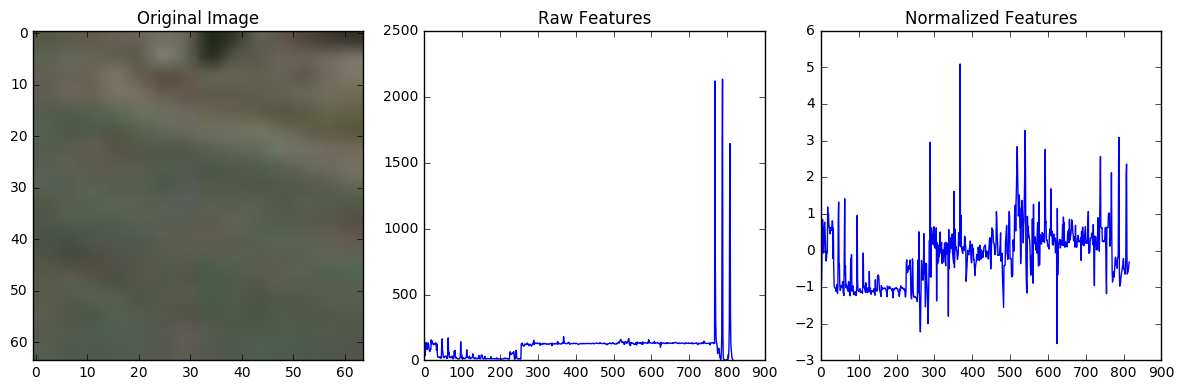

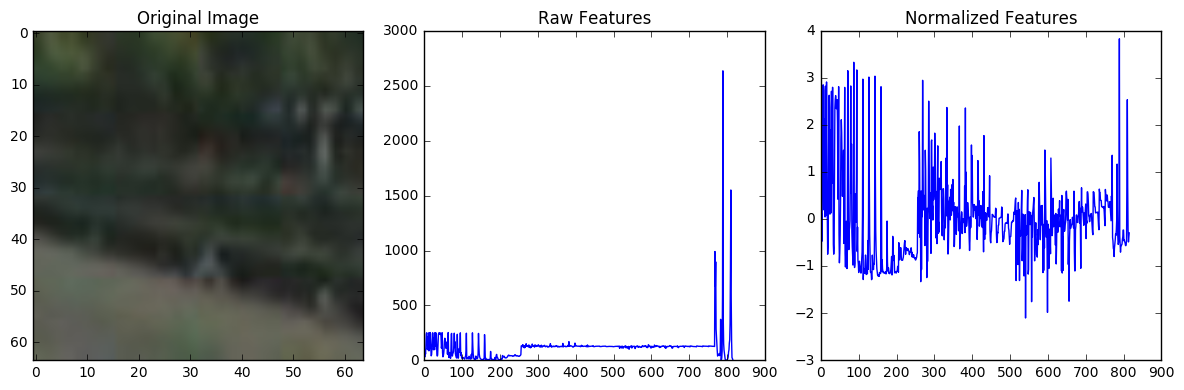

In [15]:
for _ in range(0, 2):
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    car_ind = np.random.randint(0, len(NO_VEH_SMALL))
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(NO_VEH_SMALL[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
    plt.show()

# The find_cars Function

In [16]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, 
              ystart,
              ystop,
              scale,
              svc,
              X_scaler,
              color_space,
              orient,
              pix_per_cell,
              cell_per_block,
              spatial_size,
              hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2%s' % (color_space))
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = pix_per_cell**2
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    list_detected_boxes = list()
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
                list_detected_boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return draw_img, list_detected_boxes


# Train the Classifier

In [24]:
from random import shuffle

def train_class(param_dict):
    sample_size = param_dict['sample_size']
    shuffle(VEH)
    shuffle(NO_VEH)
    cars = VEH[0:sample_size]
    notcars = NO_VEH[0:sample_size]
    
    orient = param_dict["orient"]
    pix_per_cell = param_dict["pix_per_cell"]
    cell_per_block = param_dict["cell_per_block"]
    spatial_size = param_dict["spatial_size"]
    hist_bins = param_dict["hist_bins"]
    color_space = param_dict["color_space"]
    hog_channel= param_dict["hog_channel"]
    spatial_feat = param_dict["spatial_feat"]
    hist_feat = param_dict["hist_feat"]
    hog_feat = param_dict["hog_feat"]
    
    t_start=time.time()
    car_features = extract_features(cars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    t2 = time.time()
    print(round(t2-t_start, 2), 'Seconds to extract features for car pics...')

    notcar_features = extract_features(notcars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    t3 = time.time()
    print(round(t3-t2, 2), 'Seconds to extract features for non-car pics...')

    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    t=time.time()
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.33, random_state=rand_state)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to split data...')

    print('Using:',orient,'orientations',pix_per_cell,
        'pixels per cell and', cell_per_block,'cells per block')
    print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    acc = round(svc.score(X_test, y_test), 4)
    print('Test Accuracy of SVC = ', acc)
    
    t_end = time.time()
    total_time = t_end - t_start
    
    return svc, acc, X_scaler, total_time, len(X_train[0])


In [64]:
import pickle

params = {
    'sample_size' : 1000,
    'color_space' : 'HSV', # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    'orient' : 9,  # HOG orientations
    'pix_per_cell' : 8, # HOG pixels per cell
    'cell_per_block' : 2, # HOG cells per block
    'hog_channel' : 'ALL', # Can be 0, 1, 2, or "ALL"
    'spatial_size' : (16, 16), # Spatial binning dimensions
    'hist_bins' : 16,    # Number of histogram bins
    'spatial_feat' : True, # Spatial features on or off
    'hist_feat' : True, # Histogram features on or off
    'hog_feat' : False, # HOG features on or off
}

svc, acc, X_scaler, total_time, n_features = train_class(params)

dict_res = dict()
dict_res = params.copy()
dict_res["svc"] = svc
dict_res["scaler"] = X_scaler
dict_res["acc"] = acc
dict_res["total_time"] = round(total_time,1)
dict_res["n_features"] = n_features

pickle.dump( dict_res, open( os.path.join(PROJECT_DIR, "svc_%s.p" % (np.random.randint(0, 10000) )), "wb" ) )

10.18 Seconds to extract features for car pics...
9.62 Seconds to extract features for non-car pics...
0.0 Seconds to split data...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 816
0.41 Seconds to train SVC...
Test Accuracy of SVC =  0.9197


### Compare Accuracy for different Feature Settings

In [65]:
headerKeys = ('acc', 'sample_size', 'color_space', 'hog_channel', 'hog_feat', 'spatial_feat', 'hist_feat', 'total_time', 'n_features')
print(' '.join(headerKeys))
print('-'*80)
for pickleFile in glob.glob(os.path.join(PROJECT_DIR, "svc*.p")):
    p = pickle.load( open(pickleFile, "rb") )
    if 'total_time' not in p:
        continue
    print(' \t'.join([str(p[k]) for k in headerKeys]))


acc sample_size color_space hog_channel hog_feat spatial_feat hist_feat total_time n_features
--------------------------------------------------------------------------------
0.9788 	1000 	YUV 	ALL 	True 	False 	False 	36.3 	5292
0.9773 	1000 	HSV 	2 	True 	True 	True 	41.8 	2580
0.8818 	1000 	YCrCb 	2 	True 	False 	False 	34.1 	1764
0.8348 	1000 	HLS 	2 	True 	False 	False 	26.3 	1764
0.9197 	1000 	HSV 	ALL 	False 	True 	True 	20.3 	816
0.9788 	1000 	YUV 	ALL 	True 	True 	True 	36.1 	6108
0.9364 	1000 	HSV 	2 	True 	False 	False 	27.8 	1764
0.9864 	1000 	HSV 	ALL 	True 	True 	True 	32.9 	6108
0.9682 	1000 	HSV 	ALL 	True 	False 	False 	41.1 	5292
0.9879 	1000 	YCrCb 	ALL 	True 	True 	True 	30.3 	6108
0.9455 	1000 	LUV 	2 	True 	True 	True 	45.2 	2580
0.95 	1000 	YCrCb 	2 	True 	True 	True 	37.0 	2580
0.9394 	1000 	YCrCb 	ALL 	False 	True 	True 	21.6 	816
0.9697 	100 	HSV 	2 	True 	True 	True 	4.8 	2580
0.9227 	1000 	RGB 	2 	True 	False 	False 	41.7 	1764
0.9364 	1000 	HLS 	2 	True 	Tr

# Test Of Classifier on Example Images

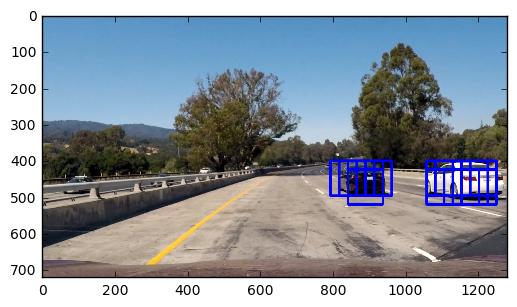

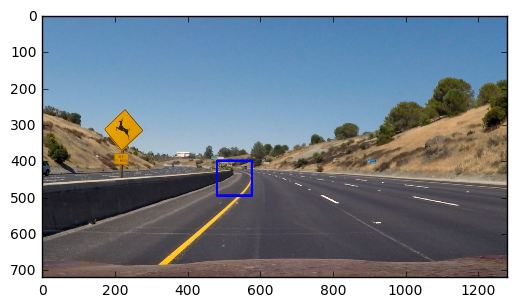

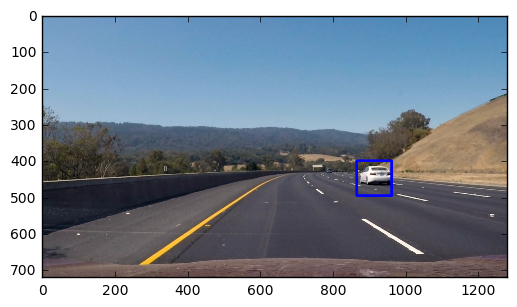

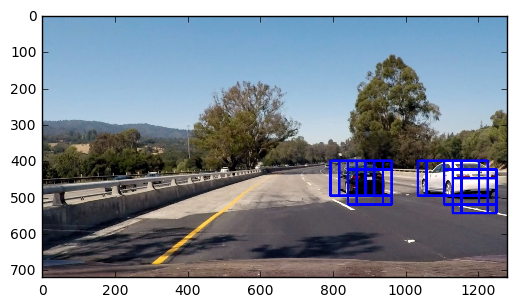

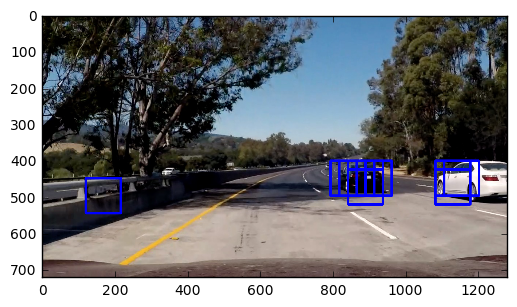

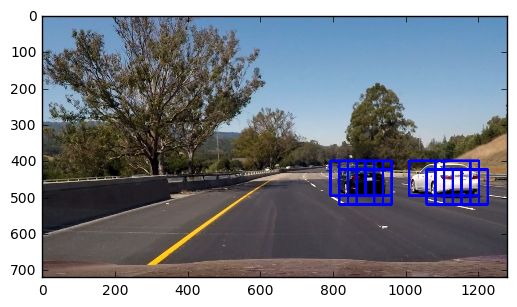

In [9]:
dist_pickle = pickle.load( open(os.path.join(PROJECT_DIR, "svc_HLS.p"), "rb" ) )
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]
color_space = dist_pickle["color_space"]

list_test_img = glob.glob(os.path.join(PROJECT_DIR, 'test_images', '*.jpg'))

for img_file in list_test_img:
    img = mpimg.imread(img_file)
    ystart = 400
    ystop = 656
    scale = 1.5
    #print(X_scaler)
    #print(ystart, ystop, scale, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    out_img, _ = find_cars(img, ystart, ystop, scale, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

    plt.imshow(out_img)
    plt.show()

# Heatmap Tools

In [10]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Test the Heatmap Tools on Example Images

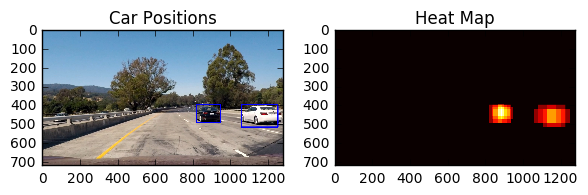

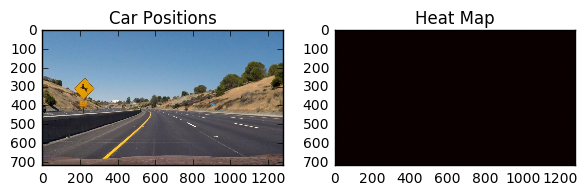

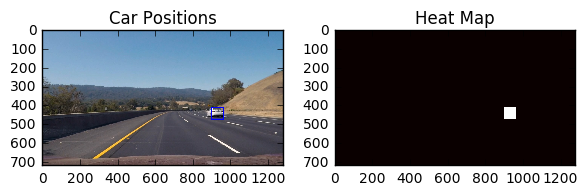

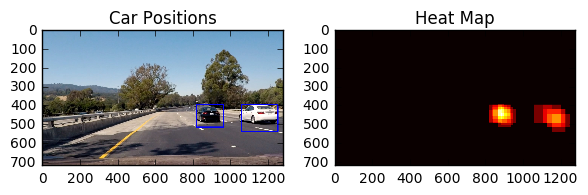

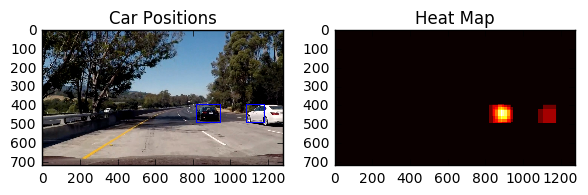

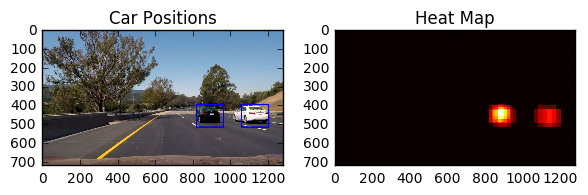

In [11]:
from scipy.ndimage.measurements import label

dist_pickle = pickle.load( open(os.path.join(PROJECT_DIR, "svc.p"), "rb" ) )
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]
color_space = dist_pickle["color_space"]

list_test_img = glob.glob(os.path.join(PROJECT_DIR, 'test_images', '*.jpg'))

for img_file in list_test_img:
    image = mpimg.imread(img_file)
    _, list_boxes1 = find_cars(image, 350, 606, 1.0, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    _, list_boxes2 = find_cars(image, 400, 656, 1.5, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    _, list_boxes3 = find_cars(image, 450, 706, 2.0, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

    list_boxes = list_boxes1 + list_boxes2 + list_boxes3
    
    # Read in image similar to one shown above 
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat, list_boxes)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)

    fig = plt.figure()
    plt.subplot(121)
    plt.imshow(draw_img)
    plt.title('Car Positions')
    plt.subplot(122)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    fig.tight_layout()
    plt.show()

# Pipeline for One Image

In [12]:
from collections import deque

class HeatMapBuffer():
    def __init__(self, buffer_size=10):
        self.lastMaps = deque()
        self.buffer_size = buffer_size
        
    def updateMaps(self, newMap):
        if len(self.lastMaps) >= self.buffer_size:
            self.lastMaps.pop()
        self.lastMaps.appendleft(newMap)
        

In [13]:
mapBuffer = HeatMapBuffer(10)

def pipeline(image):
    _, list_boxes1 = find_cars(image, 350, 606, 1.0, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    _, list_boxes2 = find_cars(image, 400, 656, 1.5, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    _, list_boxes3 = find_cars(image, 450, 706, 2.0, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

    list_boxes = list_boxes1 + list_boxes2 + list_boxes3
    
    # Read in image similar to one shown above 
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,list_boxes)

    # Avg heat over last 10 frames
    mapBuffer.updateMaps(heat)
    avgHeat = np.average(np.array(mapBuffer.lastMaps), axis=0)
    
    # Apply threshold to help remove false positives
    avgHeat = apply_threshold(avgHeat,1)
    
    # Visualize the heatmap when displaying    
    heatmap = np.clip(avgHeat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    return draw_img

# Video

In [14]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
output = 'out_test.mp4'

In [80]:

clip1 = VideoFileClip(os.path.join(PROJECT_DIR, 'project_video.mp4'))
#LINE_OBJ = Line()
out_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time out_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video out_test.mp4
[MoviePy] Writing video out_test.mp4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [43:19<00:02,  2.13s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: out_test.mp4 

Wall time: 43min 21s


In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))